# Anomaly detection on CPU usage

**Step 1** Import librarys

In [2]:
!pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 141.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 144.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 121.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 28.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 147.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 172.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 171.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 95.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np 

from datetime import datetime

import seaborn as sns
import cufflinks as cf
import plotly.offline as py
import matplotlib.pyplot as plt

from pylab import rcParams
import statsmodels.api as sm

from pmdarima.arima import auto_arima


**Step 2** Load datasets

In [4]:
url_train_a='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv'
url_train_b='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv'
url_test_a='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv'
url_test_b='https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv'

train_a=pd.read_csv(url_train_a)
train_b=pd.read_csv(url_train_b)
test_a=pd.read_csv(url_test_a)
test_b=pd.read_csv(url_test_b)

**Step 3** Dataset overview

In [5]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [6]:
train_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [7]:
train_a['datetime']=train_a['datetime'].astype('datetime64')
train_b['datetime']=train_b['datetime'].astype('datetime64')
test_a['datetime']=test_a['datetime'].astype('datetime64')
test_b['datetime']=test_b['datetime'].astype('datetime64')

In [8]:
train_a.describe(datetime_is_numeric=True)

,datetime,cpu
count,420,420.000000
mean,2017-01-27 22:11:29.999999744,1.233262
min,2017-01-27 18:42:00,0.570000
25%,2017-01-27 20:26:45,0.787500
50%,2017-01-27 22:11:30,1.110000
75%,2017-01-27 23:56:15,1.582500
max,2017-01-28 01:41:00,2.550000
std,NaN,0.505668


In [9]:
train_b.describe(datetime_is_numeric=True)

,datetime,cpu
count,600,600.000000
mean,2017-01-27 23:41:30,1.282733
min,2017-01-27 18:42:00,0.570000
25%,2017-01-27 21:11:45,0.840000
50%,2017-01-27 23:41:30,1.240000
75%,2017-01-28 02:11:15,1.610000
max,2017-01-28 04:41:00,2.550000
std,NaN,0.484951


In [10]:
test_a.describe(datetime_is_numeric=True)

,datetime,cpu
count,60,60.000000
mean,2017-01-28 02:11:29.999999744,1.271500
min,2017-01-28 01:42:00,0.680000
25%,2017-01-28 01:56:45,0.902500
50%,2017-01-28 02:11:30,1.210000
75%,2017-01-28 02:26:15,1.562500
max,2017-01-28 02:41:00,2.190000
std,NaN,0.418309


In [11]:
test_b.describe(datetime_is_numeric=True)

,datetime,cpu
count,60,60.000000
mean,2017-01-28 05:11:30,1.345833
min,2017-01-28 04:42:00,0.030000
25%,2017-01-28 04:56:45,0.070000
50%,2017-01-28 05:11:30,1.605000
75%,2017-01-28 05:26:15,2.150000
max,2017-01-28 05:41:00,2.830000
std,NaN,0.954620


We can see that train_a and test_a overlap in dates, the same is true for train_b and test_b. So, we assume that each group makes up a data set and for each dataset we will fit the same model and see how it fits.

In [12]:
train_a.set_index('datetime',inplace=True)

In [13]:
train_a.sample(10)

,cpu
datetime,
2017-01-28 01:01:00,1.87
2017-01-27 19:55:00,0.78
2017-01-27 21:34:00,0.84
2017-01-27 22:45:00,1.80
2017-01-27 19:21:00,0.65
2017-01-27 22:59:00,1.85
2017-01-27 18:52:00,1.04
2017-01-28 00:25:00,0.75
2017-01-27 23:38:00,1.41


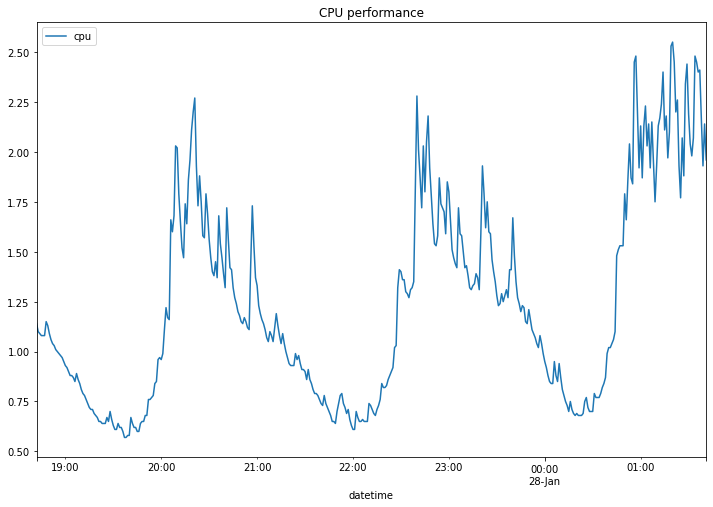

In [14]:
train_a.plot(title='CPU performance',figsize=(12,8))
plt.show()

It looks like there is a seasonality each two hours and a trend, altought it is very low. Maybe with a descomposition analysis it is easier to see.

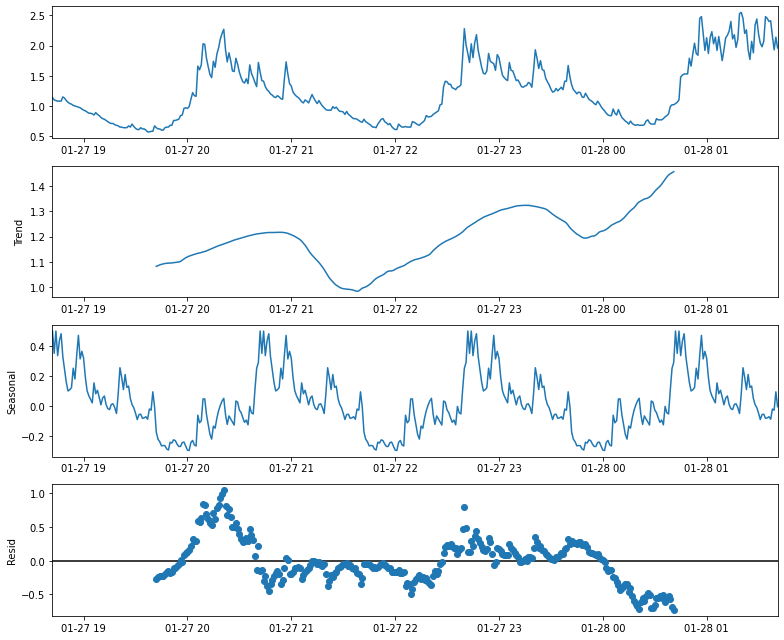

In [15]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(train_a,model='additive',period=60*2) # 2 hours period, the datetime is in minutes
fig = decomposition.plot()
plt.show()

Although we have a few observations to say anything with any certainty, we can see the seasonal component of the data, and we can also see a slightly upward trend of the data. It makes sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

**Step 4** Seasonal ARIMA model

Looking for the best parameters.

In [18]:
stepwise_model = auto_arima(train_a, start_p=1, start_q=1,
                           max_p=2, max_q=2, m=60*2,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,random_state=608)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[120]             : AIC=inf, Time=455.88 sec
 ARIMA(0,1,0)(0,1,0)[120]             : AIC=-187.268, Time=38.92 sec
 ARIMA(1,1,0)(1,1,0)[120]             : AIC=inf, Time=185.50 sec
 ARIMA(0,1,1)(0,1,1)[120]             : AIC=inf, Time=734.39 sec
 ARIMA(0,1,0)(1,1,0)[120]             : AIC=inf, Time=485.87 sec
 ARIMA(0,1,0)(0,1,1)[120]             : AIC=inf, Time=569.42 sec
 ARIMA(0,1,0)(1,1,1)[120]             : AIC=inf, Time=487.60 sec
 ARIMA(1,1,0)(0,1,0)[120]             : AIC=-185.492, Time=25.78 sec
 ARIMA(0,1,1)(0,1,0)[120]             : AIC=-185.580, Time=15.91 sec
 ARIMA(1,1,1)(0,1,0)[120]             : AIC=-189.254, Time=46.70 sec
 ARIMA(1,1,1)(1,1,0)[120]             : AIC=-241.022, Time=257.51 sec
 ARIMA(1,1,1)(2,1,0)[120]             : AIC=-242.872, Time=3358.89 sec
 ARIMA(1,1,1)(2,1,1)[120]             : AIC=inf, Time=2878.80 sec
 ARIMA(1,1,1)(1,1,1)[120]             : AIC=inf, Time=429.20 sec
 ARIMA(0,1,1)(2,1,0

In [ ]:
stepwise_model.fit(train_a) #fit the best model

NameError: name 'stepwise_model' is not defined

**Step 5** Evaluate the performance

Visual evaluation

In [ ]:
stepwise_model.fit(train_a).plot_diagnostics(figsize=(15, 12))
plt.show()

Forcasting with the model fitted

In [ ]:
future_forecast_a = stepwise_model.predict(n_periods=60) # predigo una hora

**Step 6** Actual plus prediction // Real future plus prediction

In [ ]:
pd.concat([train_a.tail(100),future_forecast_a],axis=0).plot(title='Actual plus predict CPU incidences')

In [ ]:
df_future_forecast_a = pd.DataFrame(future_forecast_a,index = test_a.index,columns=['Prediction'])
pd.concat([test_a,future_forecast_a],axis=1).plot(title='Real future plus predict CPU incidences')

In [ ]:
# Save the model as a pickle
filename = '../models/best_model_a.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))

**Step 7** Refitting the model

In [ ]:
stepwise_model.fit(train_b)
future_forecast_b = stepwise_model.predict(n_periods=60)

In [ ]:
best_model_b.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Save the model as a pickle
filename = '../models/best_model_b.pkl'
pickle.dump(stepwise_model, open(filename,'wb'))